# Animal Image Classification

This project focuses on developing and refining a neural network model for classifying animal images into four classes: "bear", "elephant", "leopard", and "zebra". The dataset used for this project is provided in the `animal-dataset.zip` file. The primary objective is to enhance the performance of a baseline model by experimenting with different architectures, hyperparameters, and techniques such as transfer learning, data augmentation, and regularization.

## Baseline Model

We start with a baseline model, which consists of an initial neural network architecture and a set of hyperparameters. This model serves as the reference point for subsequent improvements and experiments.

## Controlled Experiments

To improve upon the baseline model, we conduct a series of controlled experiments. Each candidate model differs from the baseline model by a single modification. The potential modifications include:

- **Transfer Learning**: Using pre-trained models rather than training from scratch (mandatory).
- **Different Architectures**: Experimenting with alternative neural network architectures.
- **Data Augmentation**: Applying various data augmentation techniques to increase the robustness of the model.
- **Regularization**: Implementing regularization techniques to prevent overfitting.
- **Hyperparameter Tuning**: Adjusting hyperparameters such as learning rate, batch size, and number of layers.
- **Other Modifications**: Any additional changes that might improve performance.

For each candidate model, we clearly specify the modification made and the rationale behind it. All models are trained for the same number of epochs, and their training and validation losses are compared by plotting them over epochs. We smooth the curves if necessary and share our findings and comments.

## Proposed Models

Based on the results from the controlled experiments, we propose one or more new models. These proposed models might combine multiple successful modifications, such as combining transfer learning with data augmentation. We train these models, plot the results including comparisons with the baseline and previous models, and perform a final evaluation with the best-performing model if necessary. The conclusions are summarized as a list of key findings and comments.

## Repeatability

To ensure the repeatability of our results, we implement the following practices:

- **Setting Random Seeds**: Initialize random number generator seeds for all randomness modules used (e.g., `random`, `tensorflow.random`) to ensure reproducibility.
- **Environment Reproducibility**: Specify the versions of all dependencies (e.g., TensorFlow) at the beginning of the code to enable recreating the same environment.
- **Deterministic Processes**: Avoid processes that rely on external factors such as operating system or computation power. For example, use deterministic file listing (`sorted(os.listdir())` instead of `os.listdir()`) and a fixed number of epochs rather than a time-based training budget.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import torch.optim as optim
import torch
import torchvision
from torchvision import models
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from torch import nn
from torchsummary import summary
import torch.utils.data
from sklearn.model_selection import KFold
import random
import tensorflow as tf
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# GLOBAL CONFIGS
SEED = 17
NUM_EPOCHS = 16
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4
BATCH_SIZE = 15
TRAIN_RATIO = 0.8

DATA_DIR = "/content/drive/MyDrive/HW_DL/dataset"

## Without Data Augmentation

In [ ]:
# This code block sets the random seeds for ensuring repeatability.
# Setting the PYTHONHASHSEED environment variable to the specified SEED value.
# Seeding the random module using the specified SEED value.
# Seeding the numpy module using the specified SEED value.
# Setting the seed for TensorFlow's random number generator to the specified SEED value.
# Setting the seed for PyTorch's random number generator to the specified SEED value.
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# This code block defines a transformation pipeline for image preprocessing.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a specific size
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])  # Normalize the pixel values
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=transform)

In [ ]:
total_size = len(dataset)
train_size = int(TRAIN_RATIO * total_size)  # 80% for train
val_size = total_size - train_size
print('Total dataset size:', total_size)
print('Training set size:', train_size)
print('Validation set size:', val_size)

Total dataset size: 1400
Training set size: 1120
Validation set size: 280


In [ ]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [ ]:
H = train_features.size()[2] # Height of image
W = train_features.size()[3] # Width of image
C = 4 # Number of classes

In [ ]:
# TO SHOW LABEL NAMES IN PLOTS
NUM_TO_LABEL=['BEAR','ELEPHANT','LEOPARD', 'ZEBRA']

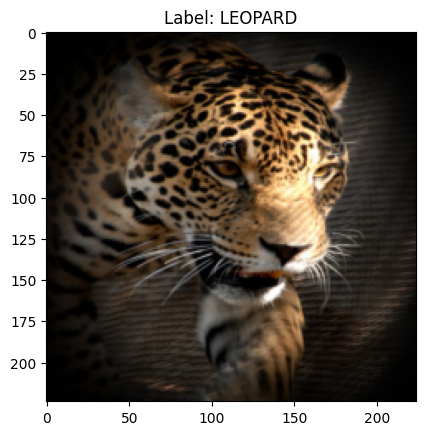

In [ ]:
img = train_features[5].squeeze()
label = train_labels[5]
imge = img.permute(1, 2, 0)  # Makes the size 224x224x3  instead of 3x224x224
plt.title(f"Label: {NUM_TO_LABEL[label]}")
plt.imshow(imge)

In [5]:
def plot(trainingEpoch_loss, validationEpoch_loss, accuracies, epochs):
  figure, axis = plt.subplots(1,2,figsize=(10, 4))
  axis[0].plot(trainingEpoch_loss, label='Training Loss')
  axis[0].plot(validationEpoch_loss,label='Validation Loss')
  axis[0].set_title("Train and Validation Loss")
  axis[1].plot(accuracies, label='Accuracy')
  axis[1].set_title("Validation Accuracy")
  axis[0].legend()
  axis[0].set_ylim(bottom=0)
  axis[1].set_ylim(bottom=0)
  axis[0].set_xlim(left=0)
  axis[1].set_xlim(left=0,right=epochs)
  axis[0].set_xlabel("Epochs")
  axis[1].set_xlabel("Epochs")

  plt.show()

In [6]:
def plot_miss_correct(image, title):
  plt.imshow(np.transpose(image, (1, 2, 0)))
  plt.title(title)
  plt.axis('off')
  plt.show()

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


In [8]:
def train_log_loss_network(model, train_loader, val_loader=None, epochs=20, device="cpu", optimizer=None):
  # CrossEntropy is another name for the Logistic Regression loss function. This is the loss we are going to minimize!
  loss_fn = nn.CrossEntropyLoss()

  # We need an optimizer! Adam is a good default one that works "well enough" for most problems
  # To tell Adam what to optimize, we give it the model's parameters - because thats what the learning will adjust
  optimizer = optim.Adam(model.parameters())

  # Devices can be spcified by a string, or a special torch object
  # If it is a string, lets get the correct device
  if device.__class__ == str:
    device = torch.device(device)

 # Place the model on the correct compute resource
  model.to(device)

  # Create lists to plot loss and accuracy
  trainingEpoch_loss = []
  validationEpoch_loss = []
  accuracies = []
  for epoch in range(epochs):
    # Put our model in training mode
    model = model.train()
    running_loss = 0.0
    training_step_loss = []
    for inputs, labels in train_loader:

      # Move the batch to the device we are using.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      y_pred = model(inputs)

      # Compute loss
      loss = loss_fn(y_pred, labels.long())

      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its parameters
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      training_step_loss.append(running_loss)

    trainingEpoch_loss.append(np.array(training_step_loss).mean())

    if val_loader is None:
      print("Loss after epoch {} is {}".format(epoch, running_loss))
    else: # Lets find out validation performance as we go!
      model = model.eval() # Set the model to "evaluation" mode, b/c we don't want to make any updates!

      # THESE ARE FOR PLOTTING
      total_val_loss=0
      targets = []
      predictions = []
      step_loss = []
      correct_images = []
      correct_labels = []
      correct_predictions = []
      misclassified_images = []
      misclassified_labels = []
      misclassified_predictions = []

      for inputs, labels in val_loader:

        # Move the batch to the device we are using
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs)

        # Get Validation Loss
        val_loss = loss_fn(y_pred, labels)
        total_val_loss += val_loss.item() * inputs.size(0)
        step_loss.append(total_val_loss)

        # Get correct and incorrect predictions, images and labels
        _, predicted = torch.max(y_pred, 1)
        for i in range(len(predicted)):
          if predicted[i] == labels[i]:
            correct_images.append(inputs[i])
            correct_labels.append(labels[i])
            correct_predictions.append(predicted[i])
          else:
            misclassified_images.append(inputs[i])
            misclassified_labels.append(labels[i])
            misclassified_predictions.append(predicted[i])
        # Get predicted classes
        # y_pred will have a shape (Batch_size, C)
        # We are asking for which class had the largest response along dimension #1, the C dimension
        for pred in torch.argmax(y_pred, dim=1).cpu().numpy():
          predictions.append(pred)
        for l in labels.cpu().numpy():
          targets.append(l)

      validationEpoch_loss.append(np.array(step_loss).mean())
      accuracy = accuracy_score(predictions, targets)
      accuracies.append(accuracy)
      print("After epoch {}, train loss is {}, validation accuracy is {}".format(epoch+1, running_loss, accuracy))

  plot(trainingEpoch_loss, validationEpoch_loss, accuracies, epochs)

  return accuracy



In [9]:
class GlobalMaxPool2d(nn.Module):
    def forward(self, input):
        return nn.functional.max_pool2d(input, kernel_size=input.size()[2:])

## Baseline Model

In [ ]:
# Baseline model refers to the initial model architecture and configuration used as a starting point
# for comparison and evaluation. It serves as a reference for assessing the performance improvements
# achieved by subsequent models or techniques.

model_fully_conv = nn.Sequential(
  nn.Conv2d(3, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(128, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  # Do a convolution with C filters, one for each class, and then perform global-max-pooling
  nn.Conv2d(128, C, 5), # it does not matter what is current H and W
  GlobalMaxPool2d(), # after global pooling H=1 and W=1
  Flatten()
)

After epoch 1, train loss is 1618.4572372436523, validation accuracy is 0.3357142857142857
After epoch 2, train loss is 1207.3877563476562, validation accuracy is 0.7107142857142857
After epoch 3, train loss is 1003.3744602203369, validation accuracy is 0.7142857142857143
After epoch 4, train loss is 869.8932571411133, validation accuracy is 0.7142857142857143
After epoch 5, train loss is 790.34681224823, validation accuracy is 0.7785714285714286
After epoch 6, train loss is 751.1877784729004, validation accuracy is 0.7428571428571429
After epoch 7, train loss is 696.0461578369141, validation accuracy is 0.7928571428571428
After epoch 8, train loss is 693.4131135940552, validation accuracy is 0.7678571428571429
After epoch 9, train loss is 621.574146270752, validation accuracy is 0.8107142857142857
After epoch 10, train loss is 538.3685293197632, validation accuracy is 0.8071428571428572
After epoch 11, train loss is 514.0208306312561, validation accuracy is 0.8321428571428572
After ep

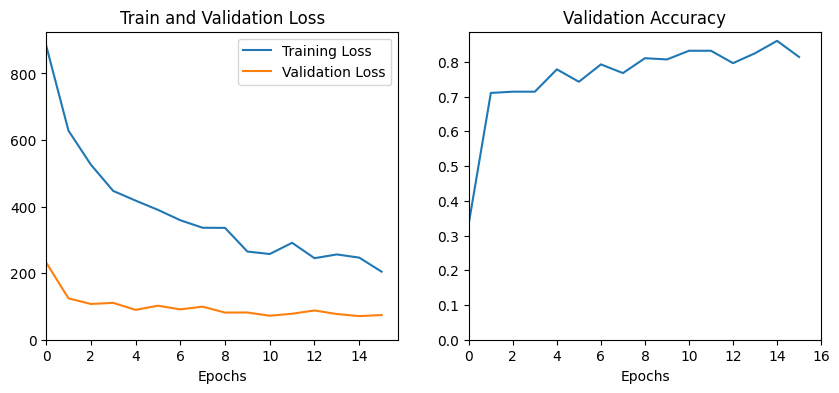

0.8142857142857143

In [ ]:
train_log_loss_network(model_fully_conv, train_loader, val_loader=val_loader, epochs=NUM_EPOCHS, device=device)

In [ ]:
# Summary works after the model is trained
summary(model_fully_conv,(3, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         Dropout2d-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          36,928
       BatchNorm2d-7         [-1, 64, 112, 112]             128
         Dropout2d-8         [-1, 64, 112, 112]               0
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
      BatchNorm2d-12          [-1, 128, 56, 56]             256
        Dropout2d-13          [-1, 128, 56, 56]               0
             ReLU-14          [-1, 128,

## Transfer Learning

### Alexnet

In [ ]:
alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 156MB/s]


In [ ]:
# Freeze model weights
for param in alexnet.parameters():
    param.requires_grad = False

In [ ]:
# Alexnet classifier
print(alexnet.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
num_features = alexnet.classifier[6].in_features
print(num_features)

4096


In [ ]:
# Here, we replace the last fully connected layer (index 6) of the AlexNet classifier with a custom sequential module.
# The original fully connected layer is replaced by the new sequential module, which consists of:
# 1. A linear layer that takes 'num_features' as input and outputs 1024 features.
# 2. A ReLU activation function to introduce non-linearity.
# 3. A dropout layer with a dropout probability of 0.5 to prevent overfitting.
# 4. Another linear layer that takes 1024 features as input and outputs 128 features.
# 5. A ReLU activation function to introduce non-linearity.
# 6. A dropout layer with a dropout probability of 0.4 to prevent overfitting.
# 7. A linear layer that takes 128 features as input and outputs 'C' classes.
# 8. A log softmax activation function applied along dimension 1 to convert raw scores into log probabilities.
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, C),
    nn.LogSoftmax(dim=1)
)

After epoch 1, train loss is 67.98454282816962, validation accuracy is 0.9571428571428572
After epoch 2, train loss is 124.97535140812761, validation accuracy is 0.925
After epoch 3, train loss is 114.64359488838818, validation accuracy is 0.95
After epoch 4, train loss is 54.806268246349646, validation accuracy is 0.9571428571428572
After epoch 5, train loss is 40.5734181649168, validation accuracy is 0.9571428571428572
After epoch 6, train loss is 65.98439426370896, validation accuracy is 0.9535714285714286
After epoch 7, train loss is 81.39924896459343, validation accuracy is 0.95
After epoch 8, train loss is 81.3448861464858, validation accuracy is 0.9571428571428572
After epoch 9, train loss is 73.84309028589632, validation accuracy is 0.9464285714285714
After epoch 10, train loss is 64.73521441430785, validation accuracy is 0.9464285714285714
After epoch 11, train loss is 50.23274027489242, validation accuracy is 0.9321428571428572
After epoch 12, train loss is 147.4091904272209,

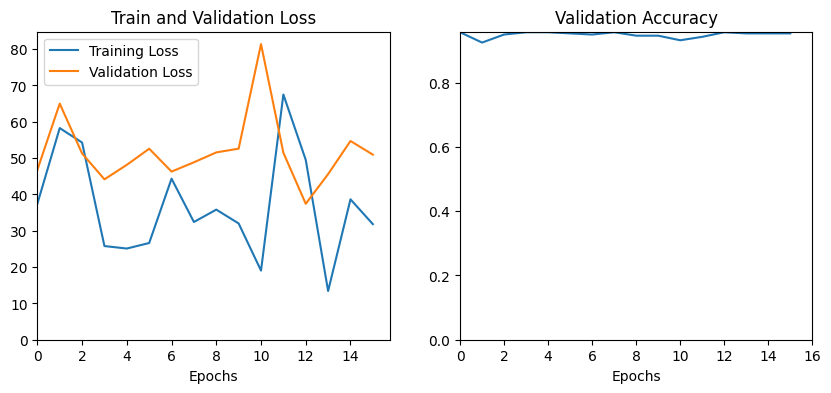

0.9535714285714286

In [ ]:
train_log_loss_network(alexnet, train_loader, val_loader, epochs=NUM_EPOCHS, device=device)

### VGG16

In [ ]:
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 146MB/s]


In [ ]:
# VGG16 classifier
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
# Freeze model weights
for param in vgg16.parameters():
    param.requires_grad = False

In [ ]:
# This will give you the number of features given to the classifier's Xth layer.
num_features = vgg16.classifier[6].in_features
print(num_features)

4096


In [ ]:
# Here, we replace the 6th layer of the classifier part of the VGG16 model with a custom sequential module.
# The original 6th layer of the classifier is replaced by the new sequential module, which consists of:
# 1. A linear layer that takes 'num_features' as input and outputs 256 features.
# 2. A ReLU activation function to introduce non-linearity.
# 3. A dropout layer with a dropout probability of 0.4 to prevent overfitting.
# 4. Another linear layer that takes 256 features as input and outputs 'C' classes.
# 5. A log softmax activation function applied along dimension 1 to convert raw scores into log probabilities.
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, C),
    nn.LogSoftmax(dim=1)
)

After epoch 1, train loss is 162.22067823633552, validation accuracy is 0.9857142857142858
After epoch 2, train loss is 47.792036743834615, validation accuracy is 0.9714285714285714
After epoch 3, train loss is 34.808965855278075, validation accuracy is 0.9857142857142858
After epoch 4, train loss is 32.35633504996076, validation accuracy is 0.9821428571428571
After epoch 5, train loss is 15.487947431858629, validation accuracy is 0.9892857142857143
After epoch 6, train loss is 15.860987035091966, validation accuracy is 0.9857142857142858
After epoch 7, train loss is 15.077811272931285, validation accuracy is 0.975
After epoch 8, train loss is 20.329956352710724, validation accuracy is 0.9821428571428571
After epoch 9, train loss is 7.034355585230514, validation accuracy is 0.9785714285714285
After epoch 10, train loss is 23.104401605785824, validation accuracy is 0.9821428571428571
After epoch 11, train loss is 10.957012653219863, validation accuracy is 0.9821428571428571
After epoch 

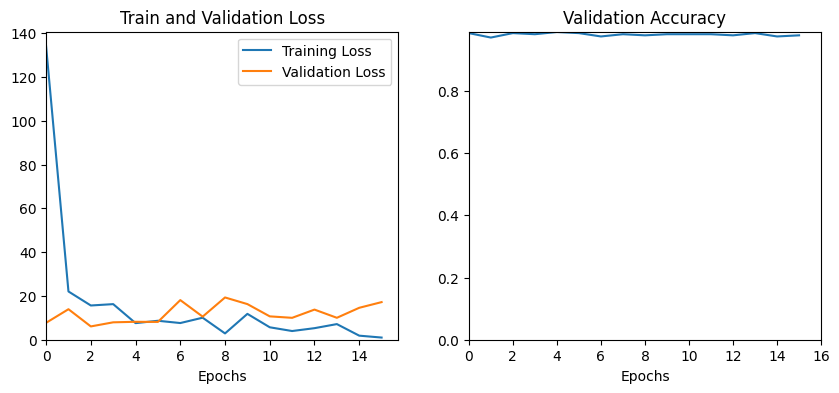

0.9785714285714285

In [ ]:
train_log_loss_network(vgg16, train_loader, val_loader, epochs=NUM_EPOCHS, device=device)

### Resnet

In [ ]:
# Load the pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [ ]:
# Freeze the pre-trained layers
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
# Resnet classifier
print(resnet.get_parameter)

<bound method Module.get_parameter of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
num_features = resnet.fc.in_features
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 512


In [ ]:
# Here, we replace the fully connected (fc) layer of the ResNet model with a custom sequential module.
# The original fully connected layer is removed, and the new sequential module consists of:
# 1. A linear layer that takes 'num_features' as input and outputs 256 features.
# 2. A ReLU activation function to introduce non-linearity.
# 3. A dropout layer with a dropout probability of 0.4 to prevent overfitting.
# 4. Another linear layer that takes 256 features as input and outputs 'C' classes.
# 5. A log softmax activation function applied along dimension 1 to convert raw scores into log probabilities.
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, C),
    nn.LogSoftmax(dim=1)
)

After epoch 1, train loss is 412.1141877770424, validation accuracy is 0.9857142857142858
After epoch 2, train loss is 75.34500271081924, validation accuracy is 0.9964285714285714
After epoch 3, train loss is 65.18030958622694, validation accuracy is 0.9928571428571429
After epoch 4, train loss is 36.14416217803955, validation accuracy is 0.9928571428571429
After epoch 5, train loss is 23.799215584993362, validation accuracy is 0.9928571428571429
After epoch 6, train loss is 29.694586616009474, validation accuracy is 0.9892857142857143
After epoch 7, train loss is 20.144932452589273, validation accuracy is 0.9892857142857143
After epoch 8, train loss is 24.360493913292885, validation accuracy is 0.9857142857142858
After epoch 9, train loss is 24.861218489706516, validation accuracy is 0.9928571428571429
After epoch 10, train loss is 22.396976597607136, validation accuracy is 0.9857142857142858
After epoch 11, train loss is 23.600965797901154, validation accuracy is 0.9928571428571429
A

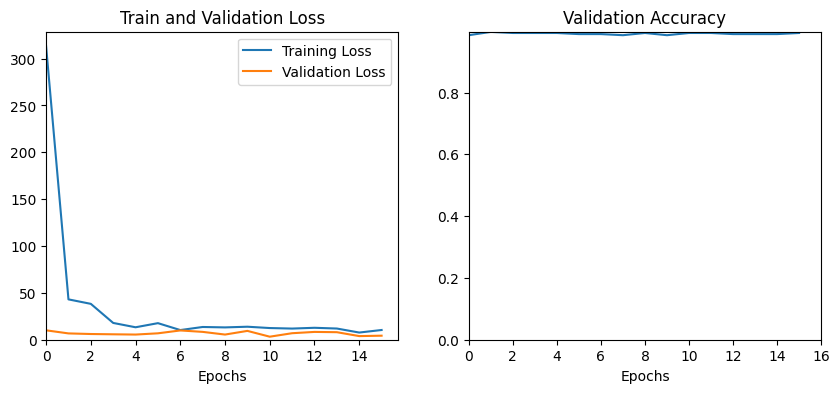

0.9928571428571429

In [ ]:
train_log_loss_network(resnet, train_loader, val_loader, epochs=NUM_EPOCHS, device=device)

### GoogleNet

In [ ]:
googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 155MB/s]


In [ ]:
# Freeze the pre-trained layers
for param in googlenet.parameters():
    param.requires_grad = False

In [ ]:
# Print the summary to get the number of layers and parameters
print(googlenet.get_parameter)

<bound method Module.get_parameter of GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0

In [ ]:
num_features = googlenet.fc.in_features
print('Number of features from pre-trained model', num_features)

Number of features from pre-trained model 1024


In [ ]:
# Here, we replace the fully connected (fc) layer of the GoogleNet model with a custom sequential module.
# The original fully connected layer is replaced by the new sequential module, which consists of:
# 1. A linear layer that takes 'num_features' as input and outputs 256 features.
# 2. A ReLU activation function to introduce non-linearity.
# 3. A dropout layer with a dropout probability of 0.4 to prevent overfitting.
# 4. Another linear layer that takes 256 features as input and outputs 'C' classes.
# 5. A log softmax activation function applied along dimension 1 to convert raw scores into log probabilities.
googlenet.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, C),
    nn.LogSoftmax(dim=1)
)

After epoch 1, train loss is 490.41276252269745, validation accuracy is 0.9642857142857143
After epoch 2, train loss is 108.40612089633942, validation accuracy is 0.9678571428571429
After epoch 3, train loss is 85.58736935257912, validation accuracy is 0.975
After epoch 4, train loss is 47.90910002589226, validation accuracy is 0.9857142857142858
After epoch 5, train loss is 57.84867073595524, validation accuracy is 0.9821428571428571
After epoch 6, train loss is 47.74271824210882, validation accuracy is 0.9892857142857143
After epoch 7, train loss is 39.52072539180517, validation accuracy is 0.9892857142857143
After epoch 8, train loss is 34.066063582897186, validation accuracy is 0.9857142857142858
After epoch 9, train loss is 18.028040263801813, validation accuracy is 0.9857142857142858
After epoch 10, train loss is 21.12011433765292, validation accuracy is 0.9857142857142858
After epoch 11, train loss is 20.727868305519223, validation accuracy is 0.9857142857142858
After epoch 12, 

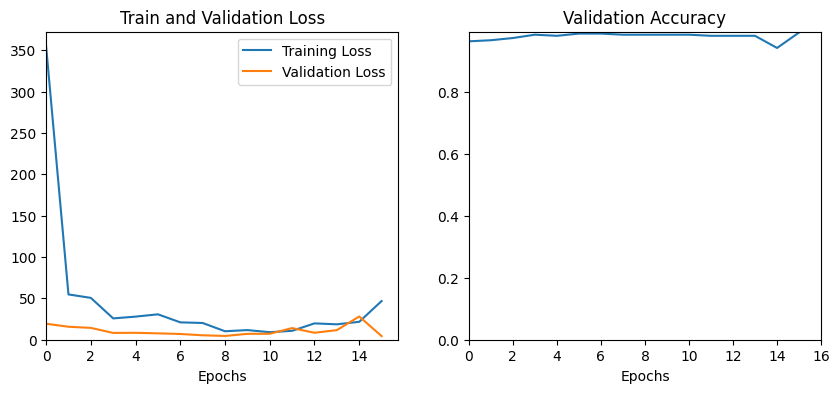

0.9928571428571429

In [ ]:
train_log_loss_network(googlenet, train_loader, val_loader, epochs=NUM_EPOCHS, device=device)

## Data Augmentation

In [10]:
# To reset seed and get the same distribution of data
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

In [28]:
# Data augmentation is a technique used to artificially increase the diversity of your training dataset
# by applying random transformations to the original data samples. This helps in improving the generalization
# and robustness of the trained model.

# Define transformations for train dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a specific size
    transforms.RandomHorizontalFlip(p=0.2),  # Flips input with a probability of 50%
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # Apply Gaussian blur
    transforms.RandomRotation(degrees=(0, 5)),  # Rotate the images randomly within the range of 0 to 5 degrees
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])  # Normalize the images
])


# Define transformations for validation dataset
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])

In [29]:
dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform= val_transform)

In [30]:
total_size = len(dataset)
train_size = int(TRAIN_RATIO * total_size)  # 80% for train
val_size = total_size - train_size
print('Total dataset size:', total_size)
print('Training set size:', train_size)
print('Validation set size:', val_size)

Total dataset size: 1400
Training set size: 1120
Validation set size: 280


In [31]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [32]:
# To reset seed and get the same distribution of data
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

In [33]:
dataset_aug = torchvision.datasets.ImageFolder(DATA_DIR, transform=train_transform)

In [34]:
train_dataset, not_val_dataset = random_split(dataset_aug, [train_size, val_size])

In [35]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([15, 3, 224, 224])
Labels batch shape: torch.Size([15])


In [37]:
H = train_features.size()[2] # Height of image
W = train_features.size()[3] # Width of image
C = 4 # Number of classes

In [38]:
# TO SHOW LABEL NAMES IN PLOTS
NUM_TO_LABEL=['BEAR','ELEPHANT','LEOPARD', 'ZEBRA']

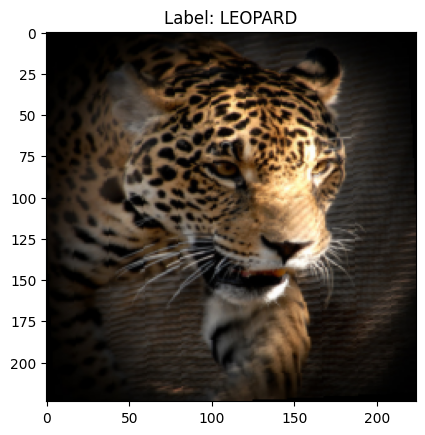

In [43]:
img = train_features[5].squeeze()
label = train_labels[5]
imge = img.permute(1, 2, 0)  # Makes the size 224x224x3  instead of 3x224x224
plt.title(f"Label: {NUM_TO_LABEL[label]}")
plt.imshow(imge)

In [44]:
model_data_aug = nn.Sequential(
  nn.Conv2d(3, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(128, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(128, C, 5),
  GlobalMaxPool2d(),
  Flatten()
)

After epoch 1, train loss is 1601.4505231380463, validation accuracy is 0.575
After epoch 2, train loss is 1278.2873871922493, validation accuracy is 0.6535714285714286
After epoch 3, train loss is 1173.5291594266891, validation accuracy is 0.675
After epoch 4, train loss is 1058.36372256279, validation accuracy is 0.6571428571428571
After epoch 5, train loss is 922.5951863825321, validation accuracy is 0.7714285714285715
After epoch 6, train loss is 954.8191055655479, validation accuracy is 0.7035714285714286
After epoch 7, train loss is 868.800396323204, validation accuracy is 0.7892857142857143
After epoch 8, train loss is 842.3245410621166, validation accuracy is 0.8035714285714286
After epoch 9, train loss is 772.4598821997643, validation accuracy is 0.7892857142857143
After epoch 10, train loss is 719.5444490760565, validation accuracy is 0.8178571428571428
After epoch 11, train loss is 749.8223741352558, validation accuracy is 0.8178571428571428
After epoch 12, train loss is 677

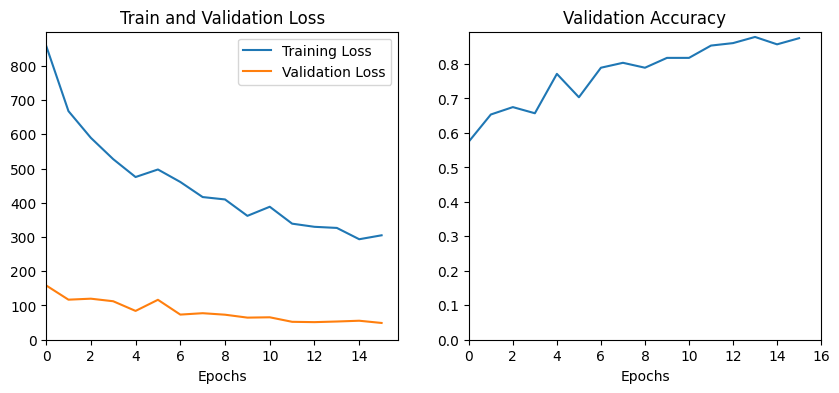

0.875

In [45]:
train_log_loss_network(model_data_aug, train_loader, val_loader=val_loader, epochs=NUM_EPOCHS, device=device)

## Regularization

In [ ]:
# To reset seed and get the same distribution of data
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# Data augmentation is a technique used to artificially increase the diversity of your training dataset
# by applying random transformations to the original data samples. This helps in improving the generalization
# and robustness of the trained model.

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a specific size
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])  # Normalize the images
])


In [ ]:
dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=transform)
total_size = len(dataset)
train_size = int(TRAIN_RATIO * total_size)  # 80% for train
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_features, train_labels = next(iter(train_loader))
H = train_features.size()[2] # Height of image
W = train_features.size()[3] # Width of image
C = 4 # Number of classes
NUM_TO_LABEL=['BEAR','ELEPHANT','LEOPARD', 'ZEBRA']

In [ ]:
model_regularization = nn.Sequential(
  nn.Conv2d(3, 64, 3, padding=1),
  nn.BatchNorm2d(64), # Batch normalization
  nn.Dropout2d(p=0.5), # More dropout added
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.5),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.5),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(128, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.5),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(128, C, 5),
  GlobalMaxPool2d(),
  Flatten()
)

After epoch 1, train loss is 1816.703531742096, validation accuracy is 0.4857142857142857
After epoch 2, train loss is 1617.1983700990677, validation accuracy is 0.5392857142857143
After epoch 3, train loss is 1509.6924528479576, validation accuracy is 0.5642857142857143
After epoch 4, train loss is 1442.0298764109612, validation accuracy is 0.45
After epoch 5, train loss is 1462.0445600152016, validation accuracy is 0.5607142857142857
After epoch 6, train loss is 1403.2967698574066, validation accuracy is 0.5428571428571428
After epoch 7, train loss is 1407.434724867344, validation accuracy is 0.5821428571428572
After epoch 8, train loss is 1347.381513118744, validation accuracy is 0.5142857142857142
After epoch 9, train loss is 1329.0613389015198, validation accuracy is 0.5571428571428572
After epoch 10, train loss is 1302.593686580658, validation accuracy is 0.6107142857142858
After epoch 11, train loss is 1273.1795793771744, validation accuracy is 0.6321428571428571
After epoch 12,

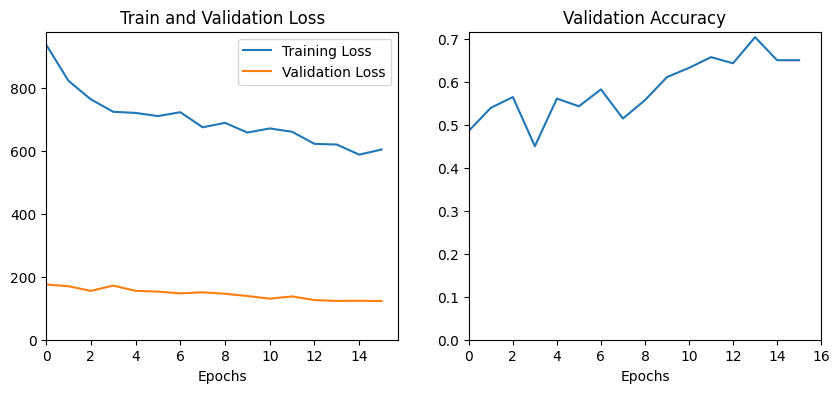

0.65

In [ ]:
# Weight decay added to optimizer
train_log_loss_network(model_regularization, train_loader, val_loader=val_loader, epochs=NUM_EPOCHS, device=device, optimizer=optim.Adam(model_data_aug.parameters(), lr=0.001, weight_decay=1e-5))

## Different Hyperparameters

In [ ]:
# Global max pool removed
# Less drop-out used

model_hyper = nn.Sequential(
  nn.Conv2d(3, 64, 3, padding=4), # Padding changed
  nn.BatchNorm2d(64),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 128, 3, padding=4),
  nn.BatchNorm2d(128),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(128, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),

  nn.Conv2d(128, 256, 3, padding=4), # Layer added
  nn.BatchNorm2d(256),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),

  nn.Conv2d(256, C, 5),
  Flatten()
)

After epoch 1, train loss is 1445.293225646019, validation accuracy is 0.5035714285714286
After epoch 2, train loss is 1160.1016825437546, validation accuracy is 0.40714285714285714
After epoch 3, train loss is 1051.5365299582481, validation accuracy is 0.4714285714285714
After epoch 4, train loss is 993.4496581554413, validation accuracy is 0.5857142857142857
After epoch 5, train loss is 912.7806021273136, validation accuracy is 0.6035714285714285
After epoch 6, train loss is 864.5382598042488, validation accuracy is 0.6464285714285715
After epoch 7, train loss is 735.9000186622143, validation accuracy is 0.6142857142857143
After epoch 8, train loss is 637.6419705152512, validation accuracy is 0.6571428571428571
After epoch 9, train loss is 586.2875984609127, validation accuracy is 0.6321428571428571
After epoch 10, train loss is 562.9307849705219, validation accuracy is 0.6214285714285714
After epoch 11, train loss is 468.46281062811613, validation accuracy is 0.6714285714285714
Afte

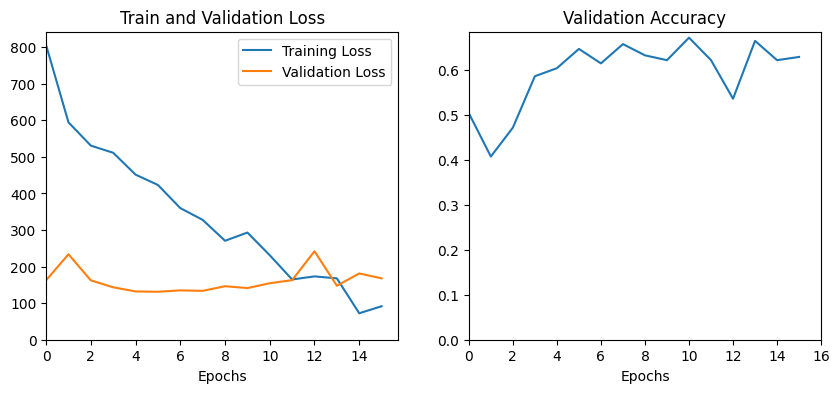

0.6285714285714286

In [ ]:
train_log_loss_network(model_hyper, train_loader, val_loader=val_loader, epochs=NUM_EPOCHS, device=device)

## Results

**How different factors might have impacted their performance:**

### Baseline Model:
- Architecture: The baseline model uses a simple convolutional neural network (CNN) architecture consisting of convolutional layers followed by batch normalization, dropout, ReLU activation, and max-pooling layers.
- Results: The validation accuracy gradually increases over epochs, reaching around 81% accuracy by epoch 15.
- Impact: The baseline model provides a foundation for comparison with more complex models. Its simplicity might limit its capacity to capture intricate patterns in the data, resulting in lower accuracy.
- Potential Issue: The model may lack the depth and complexity necessary to capture intricate patterns in the data, resulting in limited performance.


### Transfer Learning (AlexNet):
- Architecture: Transfer learning involves replacing the last fully connected layer of the AlexNet classifier with a custom sequential module. It retains the pre-trained weights of the earlier layers.
- Results: Achieves higher validation accuracy compared to the baseline, reaching around 95% accuracy.
- Impact: Transfer learning leverages the pre-trained features of AlexNet, which are learned from a large dataset (ImageNet). This helps in extracting more abstract and general features relevant to the task, leading to improved performance.
- Potential Issue: If the dataset significantly differs from the original dataset used to pre-train AlexNet (e.g., differences in image characteristics, classes), it might lead to suboptimal performance.

### Transfer Learning 2 (VGG16):
- Architecture: Similar to the previous transfer learning approach, here, the last fully connected layer of VGG16 is replaced with a custom sequential module.
- Results: Achieves the highest validation accuracy among the presented models, around 98.6%.
- Impact: VGG16 is a deeper network compared to AlexNet, potentially allowing it to capture more intricate features. The custom sequential module further fine-tunes the model for the specific task, contributing to its superior performance.
- Potential Issue: Overfitting might occur if the model's capacity is too high relative to the size and complexity of the dataset.

### Data Augmentation:
- Approach: Data augmentation involves applying various transformations to the input images during training, such as random horizontal flips, color jitter, Gaussian blur, and random rotation.
- Results: Despite augmentation, the model's validation accuracy starts relatively low and improves gradually and at the and 87.5 accuracy is better than base experiment
- Impact: Data augmentation introduces additional variations to the training data, making the model more robust and less prone to overfitting. However, excessive augmentation or inappropriate transformations might lead to noisy or irrelevant features, impacting performance.


### Regularization Added:
- Approach: Regularization techniques like dropout and weight decay are applied to the baseline model to prevent overfitting.
- Impact: Regularization techniques help prevent overfitting by introducing noise or constraints during training. However, excessive regularization might hinder the model's capacity to capture relevant patterns, leading to suboptimal performance.
- Results: While regularization stabilizes training, it does not significantly improve performance compared to other models.
- Potential Issue: The dropout rates or weight decay coefficient might not be properly tuned, leading to insufficient regularization or underfitting.



### Different Hyperparameters:
- Approach: Changes are made to the hyperparameters and architecture, such as padding, dropout rate, and additional convolutional layers.
- Impact: Hyperparameters like dropout rate and padding affect the model's capacity to generalize. Suboptimal choices may lead to underfitting or overfitting, affecting performance. Additionally, adding more layers might increase the model's capacity to capture complex patterns, but it also increases the risk of overfitting if not balanced properly.
- Results: The model exhibits varying performance, starting with a validation accuracy around 50.4% and fluctuating during training.
- Potential Issue: Inadequate hyperparameter tuning might lead to suboptimal performance, with some configurations not effectively capturing the dataset's underlying patterns.




**Based on the results provided, the preferable model among the ones presented is Transfer Learning 2 (VGG16). This model achieved the highest validation accuracy, around 98.6%, indicating superior performance compared to the other models. Transfer learning from a pre-trained VGG16 network likely allowed the model to leverage more intricate features, resulting in better classification accuracy.**

**On the other hand, the model labeled as Different Hyperparameters appears to be less preferable. While it introduces changes to hyperparameters and architecture, such as padding, dropout rate, and additional convolutional layers, it achieved moderate validation accuracy, ranging from 47-67%. This suggests that the chosen hyperparameters and architectural changes might not have been optimal, resulting in suboptimal performance compared to the baseline model.**